# LJ Tutorial 

Environment setup
```
git clone git@github.com:jennyfothergill/msibi.git
cd msibi
conda env create -f environment.yml
conda activate msibi
pip install -e .
```

In [1]:
import itertools

import freud
import gsd
import gsd.hoomd
import hoomd
import hoomd.md
import matplotlib.pyplot as plt
import numpy as np

from msibi import MSIBI, State, Pair, mie

In [2]:
# msibi/workers.py turns on logging which borks jupyter lab
# especially for matplotlib and gsd file reading
# this cell will turn it off

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

Remove old runs: only the rdf targets, run and run_template scripts, and the start.hoomdxml remain.

In [14]:
%%bash
rm state*/_* rdfs/pair* potentials/* f_fits.log state*/log.txt
rm state*/err.txt
rm state*/query.dcd

rm: state*/_*: No such file or directory
rm: rdfs/pair*: No such file or directory
rm: f_fits.log: No such file or directory


Create the trajectories at the three statepoints... takes about 40 minutes on 2.2 GHz Intel Core i7.

In [3]:
kTs = [0.5, 1.5, 2.0]
n = 12
n_particles = n**3

In [5]:
# This cell takes 40 minutes. Don't rerun it unless you have a good reason.
for i,kT in enumerate(kTs):
    hoomd.context.initialize("")
    system = hoomd.init.create_lattice(
        unitcell = (hoomd.lattice.sc(a=1.58, type_name="A")), 
        n = n,
    )
    
    nl = hoomd.md.nlist.cell()
    lj = hoomd.md.pair.lj(r_cut=2.5, nlist=nl)
    lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0)
    hoomd.md.integrate.mode_standard(dt=0.001)
    _all = hoomd.group.all()
    nvt = hoomd.md.integrate.nvt(group=_all, kT=kT, tau=1)
    nvt.randomize_velocities(seed=23)
    hoomd.analyze.log(
        filename=f'state{i}/LJ_kT{kT}.log',
        quantities=["time", "temperature", "potential_energy"],
        period=100,
        overwrite=True
    )
    hoomd.dump.gsd(f'state{i}/trajectory{kT}.gsd', period=5e3, group=_all, overwrite=True)
    hoomd.run(1e6)

HOOMD-blue 2.9.2 DOUBLE HPMC_MIXED TBB SSE SSE2 SSE3 
Compiled: 06/26/2020
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, J Glaser, and S C Glotzer. "HOOMD-blue: A Python package for
  high-performance molecular dynamics and hard particle Monte Carlo
  simulations", Computational Materials Science 173 (2020) 109363
-----
HOOMD-blue is running on the CPU
notice(2): Group "all" created containing 1728 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 1728
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 13201 / 1000000 | TPS 1319.85 | ETA 00:12:27
Time 00:00:20 | Step 23344 / 1000000 | TPS 1014.22 | ETA 00:16:02
Time 00:00:30 | Step 32401 / 1000000 | TPS 905.173 | ETA 00:17:48
Time 00:00:40 | Step 41164 / 1000000 | TPS 876.287 |

Check that the system is equilibrated.

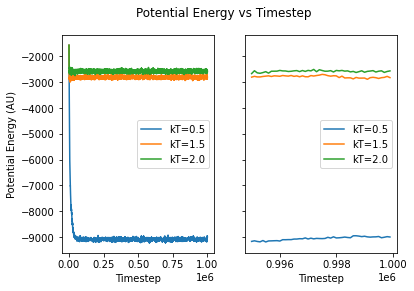

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.suptitle("Potential Energy vs Timestep")
for i, kT in enumerate(kTs):   
    log = np.loadtxt(f'state{i}/LJ_kT{kT}.log', skiprows=1)
    ax1.plot(log[:,0],log[:,3], label=f"kT={kT}")
    ax2.plot(log[-50:,0],log[-50:,3], label=f"kT={kT}")
    ax1.set_xlabel("Timestep")
    ax2.set_xlabel("Timestep")
    ax1.set_ylabel("Potential Energy (AU)")
    ax1.legend()
    ax2.legend()

Last 50 frames look equilibrated (TODO autocorrelation?) so we'll calculate the RDF of those.

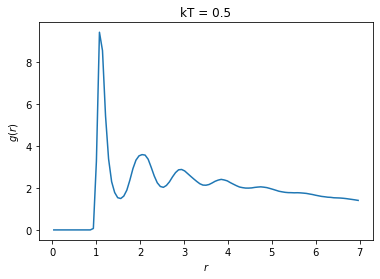

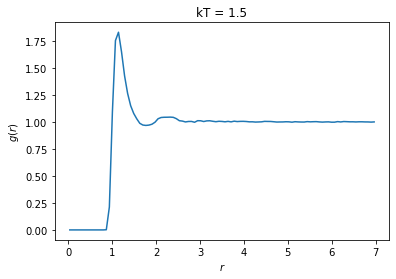

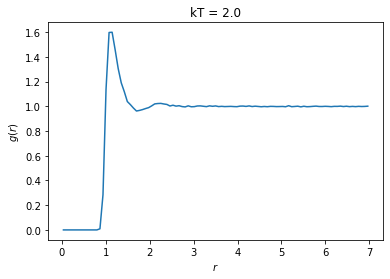

In [7]:
for i,kT in enumerate(kTs):
    gsdfile = f'state{i}/trajectory{kT}.gsd'
    with gsd.hoomd.open(gsdfile) as t:
        rdf = freud.density.RDF(bins=101, r_max=7)
        for snap in t[-50:]:
            rdf.compute(system=snap, reset=False)
        data = np.stack((rdf.bin_centers, rdf.rdf)).T
        np.savetxt(f"rdfs/rdftarget{i}", data)
        rdf.plot()
        plt.title(f"kT = {kT}")

Set up global parameters:

- rdf_cutoff specifies how far out to calculate the rdf
- pot_cutoff specifies where to cut off the IBI calculation of the potential. The tail of the potential function (by default the last 5 points will be smoothed to zero using the [XPLOR smoothing function](https://hoomd-blue.readthedocs.io/en/stable/module-md-pair.html#hoomd.md.pair.pair). Small r values of the potential are also corrected using a linear correction by default. 
- smooth_rdfs if True, applies a Savitzky-Golay filter to the rdf array

TODO: this notebook should 
- show lj run √, 
- calculation of rdf √, 
- and prove that starting with the boltzmann inverse can iterate closer to "true" potential

- currently using mdtraj to load trajectory (dcd) and compute rdf--switch to freud and gsd?

- switch dcd to gsd?

- also why not show the smoothing etc?

In [4]:
rdf_cutoff = 5.0
opt = MSIBI(
    rdf_cutoff=rdf_cutoff, n_rdf_points=101, pot_cutoff=3.0, smooth_rdfs=True
)

Specify states

In [5]:
state0 = State(
    kT=0.5, 
    state_dir='./state0', 
    top_file='trajectory0.5.gsd',
    traj_file='trajectory0.5.gsd',
    name='state0', 
    backup_trajectory=True
)
state1 = State(
    kT=1.5, 
    state_dir='./state1', 
    top_file='trajectory1.5.gsd',
    traj_file='trajectory1.5.gsd',
    name='state1',
    backup_trajectory=True
)
state2 = State(
    kT=2.0, 
    state_dir='./state2', 
    top_file='trajectory2.0.gsd',
    traj_file='trajectory2.0.gsd',
    name='state2', 
    backup_trajectory=True
)
states = [state0, state1, state2]

Specify pairs

In [6]:
# all-all for n_particles atoms
# TODO use freud neighborlist?
# TODO write some logic to automate indices generation
indices = list(itertools.combinations(range(n_particles), 2))  

# 1-D array of potential values.
#TODO shouldn't this be boltzmann inverse?
initial_guess = mie(opt.pot_r, 1.0, 1.0)  # np array shape (61,)
rdf_targets = [
    np.loadtxt(f"rdfs/rdftarget{i}") for i in range(3)
]

pair0 = Pair('1', '1', initial_guess)
alphas = [1.0, 1.0, 1.0]

/Users/jenny/Projects/msibi/msibi/potentials.py:42: RuntimeWarning: divide by zero encountered in true_divide
  return prefactor * eps * ((sig / r) ** m - (sig / r) ** n)
/Users/jenny/Projects/msibi/msibi/potentials.py:42: RuntimeWarning: invalid value encountered in subtract
  return prefactor * eps * ((sig / r) ** m - (sig / r) ** n)


Add targets to pair

In [7]:
for state, target, alpha in zip(states, rdf_targets, alphas):
    pair0.add_state(state, target, alpha, indices)
pairs = [pair0]  # optimize() expects a list of pairs

Implement MSIBI algorithm

In [8]:
# Turn back on logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)

TODO next
- find where it is still using hoomdxml even though new top file is supplied??

In [10]:
opt.optimize(states, pairs, n_iterations=5, engine='hoomd')

/Users/jenny/miniconda3/envs/msibi/lib/python3.8/site-packages/mdtraj/core/trajectory.py:422: UserWarning: top= kwarg ignored since file contains topology information
  warnings.warn('top= kwarg ignored since file contains topology information')
/Users/jenny/Projects/msibi/msibi/pair.py:189: RuntimeWarning: invalid value encountered in true_divide
  self.potential += (kT * alpha * np.log(current_rdf / target_rdf) /
/Users/jenny/Projects/msibi/msibi/pair.py:189: RuntimeWarning: divide by zero encountered in log
  self.potential += (kT * alpha * np.log(current_rdf / target_rdf) /
/Users/jenny/Projects/msibi/msibi/pair.py:189: RuntimeWarning: invalid value encountered in multiply
  self.potential += (kT * alpha * np.log(current_rdf / target_rdf) /


RuntimeError: Undefined values in tail of potential.This probably means you need better sampling at this state point.

Plot results

In [2]:
import matplotlib.pyplot as plt

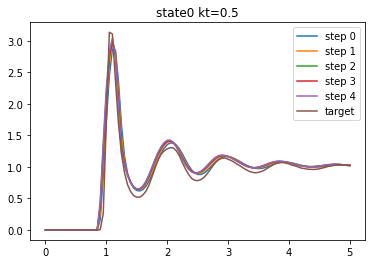

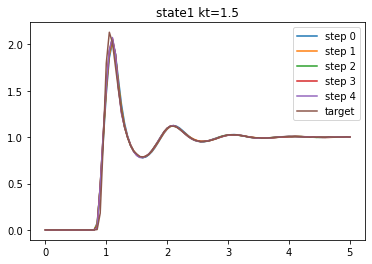

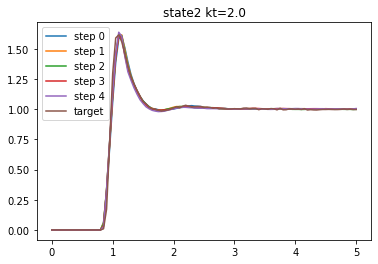

In [45]:
for state in states:
    plt.title(f'{state.name} kt={state.kT}')
    
    for step in range(0,opt.n_iterations):
        try:
            step_rdf = np.loadtxt(f'rdfs/pair_1-1-state_{state.name}-step{step}.txt')
            plt.plot(step_rdf[:,0],step_rdf[:,1], label=f'step {step}')
        except OSError:
            target = np.loadtxt(f'rdfs/rdf.target{state.name.strip("state")}.t1t1.txt')
            plt.plot(target[:,0], target[:,1], label='target')
            plt.legend()
            plt.show()
            break

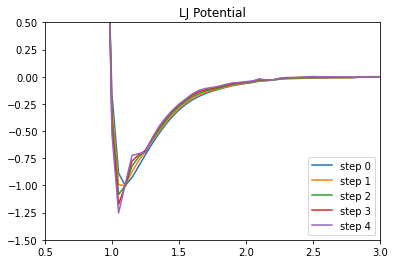

In [60]:
for step in range(0,opt.n_iterations):
    plt.ylim([-1.5,0.5])
    plt.xlim([0.5,3])
    plt.title("LJ Potential")
    try:
        step_pot = np.loadtxt(f'potentials/step{step}.pot.1-1.txt')
        plt.plot(step_pot[:,0],step_pot[:,1], label=f'step {step}')
    except OSError:
        plt.legend()
        plt.show()
        break

what potential was used to generate the targets?

In [65]:
from MDAnalysis.lib.formats.libdcd import DCDFile

In [70]:
with DCDFile('state0/query.dcd') as f:
    for frame in f:
        pass
print(frame.xyz)

[[-4.9447665  4.982726   2.500051 ]
 [-3.6839077 -4.326487   2.6648674]
 [ 3.8916466 -1.7114909 -4.8555593]
 ...
 [-0.8723145  2.4930065  2.9952328]
 [ 2.6854112 -1.4036062 -1.6191419]
 [-3.33116    3.018204   2.0835867]]
